In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/House_Price_Prediction")
!ls

HousePricePrediction.xlsx   predict_prices.ipynb
house_pricepreiction.ipynb  README.md


In [6]:
# !pip install openpyxl

In [7]:
# pip install pandas scikit-learn matplotlib seaborn

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [9]:
# --- Step 1: Load and Explore the Data ---
house = pd.read_excel("HousePricePrediction.xlsx")
house.head()

,Id,Area,Configuration,Type,Overall Condition,Year Built,Year Renovated,Exterior,Sale Price
0,0,8450,Inside,1Fam,5,2003,2003,VinylSd,208500.0
1,1,9600,FR2,1Fam,8,1976,1976,MetalSd,181500.0
2,2,11250,Inside,1Fam,5,2001,2002,VinylSd,223500.0
3,3,9550,Corner,1Fam,5,1915,1970,Wd Sdng,140000.0
4,4,14260,FR2,1Fam,5,2000,2000,VinylSd,250000.0


In [10]:
house.keys()

Index(['Id', 'Area', 'Configuration', 'Type', 'Overall Condition',
       'Year Built', 'Year Renovated', 'Exterior', 'Sale Price'],
      dtype='object')

In [11]:
house.shape

(2919, 9)

In [12]:
house.size

26271

In [13]:
# descriptive statistics for numerical columns
house.describe()

,Id,Area,Overall Condition,Year Built,Year Renovated,Sale Price
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1459.000000,10168.114080,5.564577,1971.312778,1984.264474,180921.195890
std,842.787043,7886.996359,1.113131,30.291442,20.894344,79442.502883
min,0.000000,1300.000000,1.000000,1872.000000,1950.000000,34900.000000
25%,729.500000,7478.000000,5.000000,1953.500000,1965.000000,129975.000000
50%,1459.000000,9453.000000,5.000000,1973.000000,1993.000000,163000.000000
75%,2188.500000,11570.000000,6.000000,2001.000000,2004.000000,214000.000000
max,2918.000000,215245.000000,9.000000,2010.000000,2010.000000,755000.000000


In [14]:
# summary of the dataset (column names, non-null counts, data types)
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 2919 non-null   int64  
 1   Area               2919 non-null   int64  
 2   Configuration      2919 non-null   object 
 3   Type               2919 non-null   object 
 4   Overall Condition  2919 non-null   int64  
 5   Year Built         2919 non-null   int64  
 6   Year Renovated     2919 non-null   int64  
 7   Exterior           2918 non-null   object 
 8   Sale Price         1460 non-null   float64
dtypes: float64(1), int64(5), object(3)
memory usage: 205.4+ KB


In [15]:
print(f"Missing Values:\n{house.isnull().sum()}")
print(f"Duplicates Values:{ house.duplicated().sum()}")

Missing Values:
Id                      0
Area                    0
Configuration           0
Type                    0
Overall Condition       0
Year Built              0
Year Renovated          0
Exterior                1
Sale Price           1459
dtype: int64
Duplicates Values:0


In [29]:
house.Exterior.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: Exterior
Non-Null Count  Dtype 
--------------  ----- 
2918 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [17]:
house["Sale Price"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: Sale Price
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 22.9 KB


In [18]:
print(f'Total null values in "Sale Price" is {2919-1460}')

Total null values in "Sale Price" is 1459


In [19]:
# Handle Missing Values (if any)
# For simplicity, we'll fill any missing numerical values with the median.
for col in house.select_dtypes(include=np.number).columns:
    if house[col].isnull().sum() > 0:
        median_val = house[col].median()
        house[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median value: {median_val}")

Filled missing values in 'Sale Price' with median value: 163000.0


/tmp/ipython-input-19-3459250481.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  house[col].fillna(median_val, inplace=True)


In [20]:
print(f"Missing Values:\n{house.isnull().sum()}")

Missing Values:
Id                   0
Area                 0
Configuration        0
Type                 0
Overall Condition    0
Year Built           0
Year Renovated       0
Exterior             1
Sale Price           0
dtype: int64


In [21]:
# Handle Categorical Features using One-Hot Encoding
# This converts columns like 'Configuration' into numerical columns
print("\n--- Converting Categorical Features ---")
categorical_cols = house.select_dtypes(include='object').columns
print(f"Categorical columns to be one-hot encoded: {list(categorical_cols)}")
df_model = pd.get_dummies(house, columns=categorical_cols, drop_first=True)
print("Shape of data after one-hot encoding:", house.shape)
print("New columns:", house.columns)
print("\n")


--- Converting Categorical Features ---
Categorical columns to be one-hot encoded: ['Configuration', 'Type', 'Exterior']
Shape of data after one-hot encoding: (2919, 9)
New columns: Index(['Id', 'Area', 'Configuration', 'Type', 'Overall Condition',
       'Year Built', 'Year Renovated', 'Exterior', 'Sale Price'],
      dtype='object')




In [22]:
# Prepare data for modeling
# Use the one-hot encoded dataframe df_model
x = df_model.drop('Sale Price', axis=1)
y = df_model['Sale Price']
x.head()

,Id,Area,Overall Condition,Year Built,Year Renovated,Configuration_CulDSac,Configuration_FR2,Configuration_FR3,Configuration_Inside,Type_2fmCon,...,Exterior_CemntBd,Exterior_HdBoard,Exterior_ImStucc,Exterior_MetalSd,Exterior_Plywood,Exterior_Stone,Exterior_Stucco,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing
0,0,8450,5,2003,2003,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,1,9600,8,1976,1976,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2,11250,5,2001,2002,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,3,9550,5,1915,1970,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,4,14260,5,2000,2000,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [23]:
y.head()

,Sale Price
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0


In [24]:
# Split data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Training set size: {x_train.shape[0]} samples")
print(f"Testing set size: {x_test.shape[0]} samples")
print("\n")

Training set size: 2335 samples
Testing set size: 584 samples




In [25]:
# --- Step 3: Model Building and Training ---

print("--- Training the Model ---")
# Initialize the RandomForestRegressor model
# n_estimators is the number of trees in the forest.
# random_state ensures we get the same result every time we run the code.
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
model.fit(x_train, y_train)
print("Model training complete!")
print("\n")

--- Training the Model ---
Model training complete!




In [26]:
# --- Step 4: Model Evaluation ---

print("--- Evaluating the Model ---")
# Make predictions on the unseen test data
y_pred = model.predict(x_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R-squared (R²): {r2:.4f}")
print("\n")

--- Evaluating the Model ---
Mean Absolute Error (MAE): $18,241.07
R-squared (R²): 0.5208




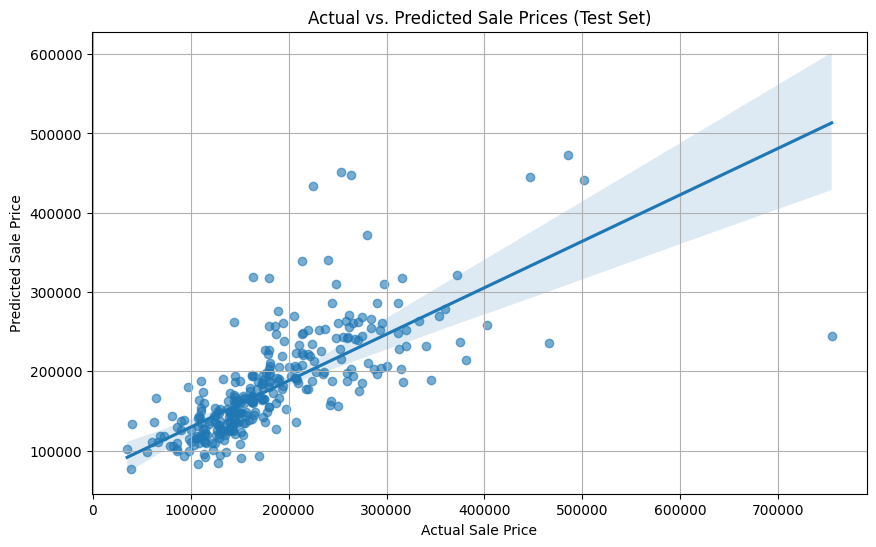

In [ ]:
# --- Visualize Predictions vs. Actual Prices ---

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6})
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Prices (Test Set)")
plt.grid(True)
plt.show()

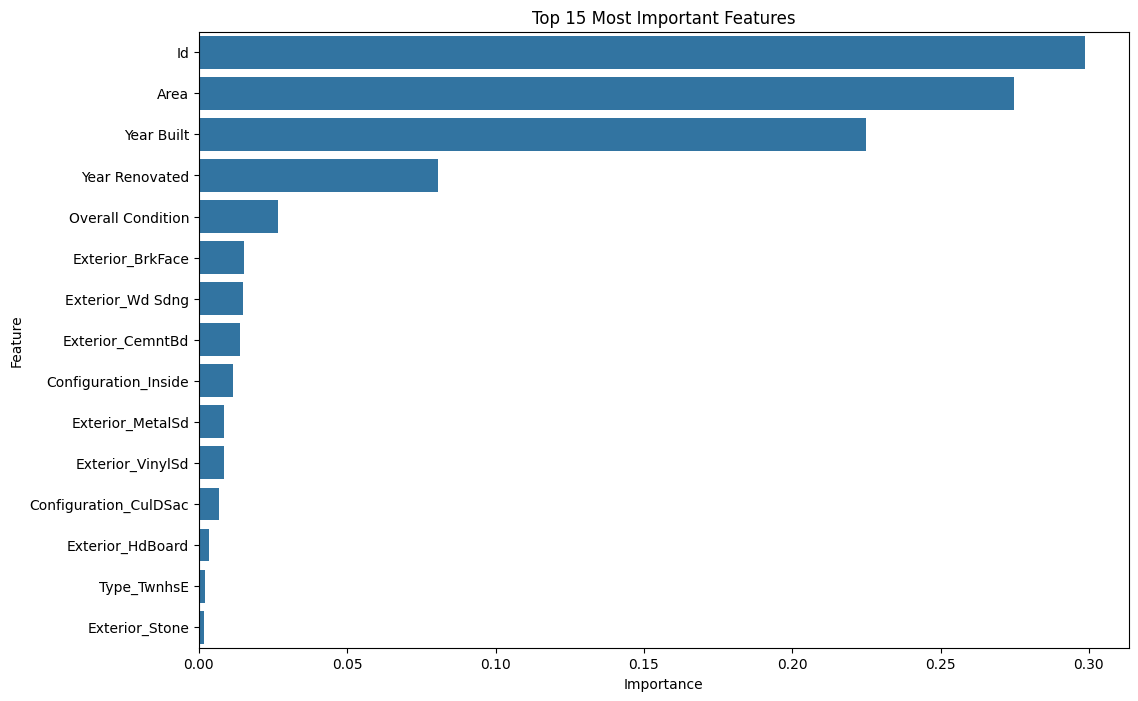

In [ ]:
# Let's see which features the model found most important
importances = model.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features')
plt.show()

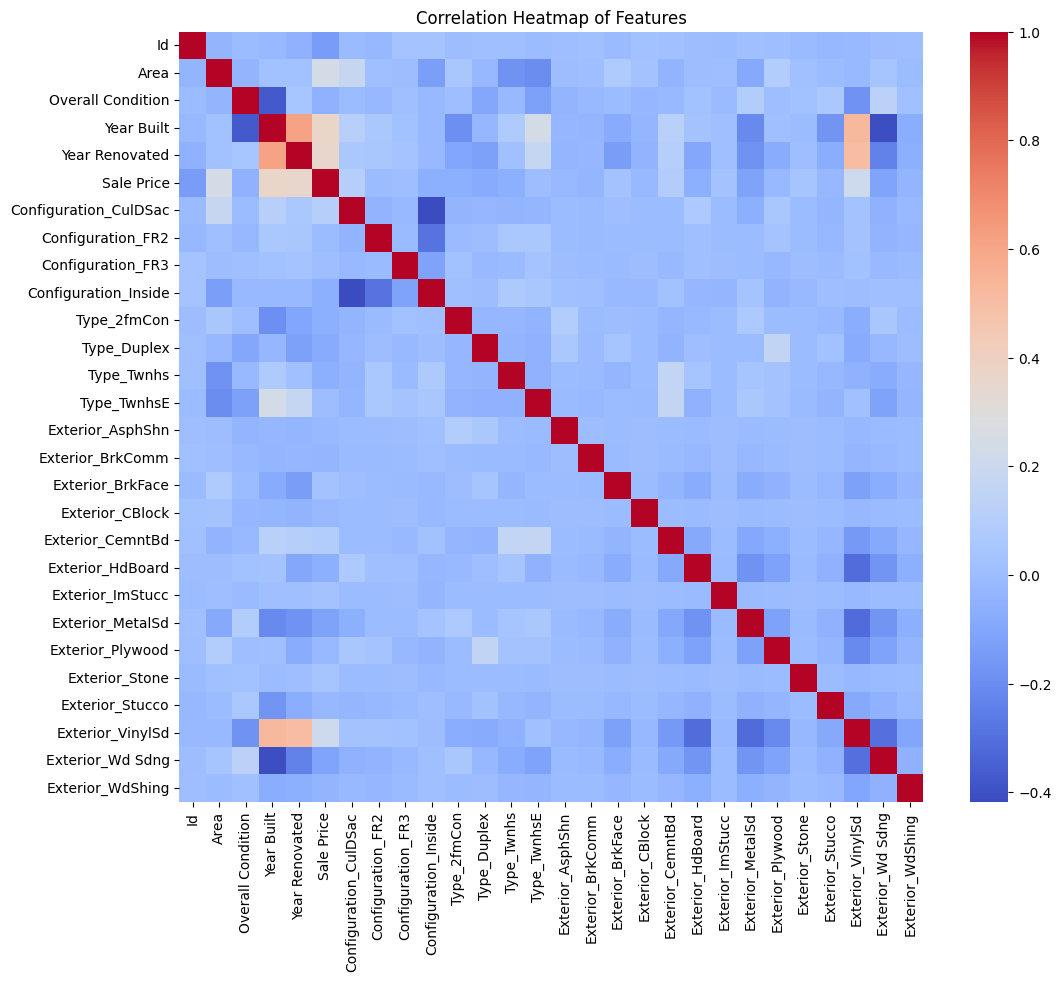

In [30]:
# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df_model.corr(), cmap='coolwarm', annot=False) # Set annot=True to show correlation values
plt.title('Correlation Heatmap of Features')
plt.show()

In [31]:
# Select two samples from the original data
sample_tests = house.sample(2, random_state=42)

# Apply the same preprocessing steps as the training data
# 1. Handle missing values (although we filled numerical NaNs earlier, let's ensure consistency)
for col in sample_tests.select_dtypes(include=np.number).columns:
    if sample_tests[col].isnull().sum() > 0:
        median_val = house[col].median() # Use median from the original training data
        sample_tests[col].fillna(median_val, inplace=True)

# 2. One-hot encode categorical features
categorical_cols = sample_tests.select_dtypes(include='object').columns
sample_tests_processed = pd.get_dummies(sample_tests, columns=categorical_cols, drop_first=True)

# Ensure the sample test data has the same columns as the training data
# Add missing columns with a value of 0
missing_cols = set(x_train.columns) - set(sample_tests_processed.columns)
for c in missing_cols:
    sample_tests_processed[c] = 0

# Ensure the order of columns is the same
sample_tests_processed = sample_tests_processed[x_train.columns]

# Predict the sale price
predicted_prices = model.predict(sample_tests_processed)

# Display the original sample data and the predicted prices
print("Sample Test Cases:")
display(sample_tests)
print("\nPredicted Sale Prices:")
for i, price in enumerate(predicted_prices):
    print(f"Sample {i+1}: ${price:,.2f}")

Sample Test Cases:


,Id,Area,Configuration,Type,Overall Condition,Year Built,Year Renovated,Exterior,Sale Price
2437,2437,6760,Inside,1Fam,5,1962,1962,HdBoard,163000.0
2470,2470,9780,Inside,1Fam,9,1950,2005,VinylSd,163000.0



Predicted Sale Prices:
Sample 1: $163,000.00
Sample 2: $163,000.00
